# Kaggle GenAI text detection

Inspired by [this](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview) competition. I avoided looking at any solutions. 

Modeling was done in a `conda python 3.10` environment on an AWS `ml.g5.12xlarge` (unfortuantely for my wallet) instance. 

## EDA

First, load in the train and test sets and explore word frequencies

I downloaded the data [here](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset)

In [2]:
#! pip install accelerate && pip install bitsandbytes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#! pip install accelerate

In [3]:
train = pd.read_csv('train_v2_drcat_02.csv')

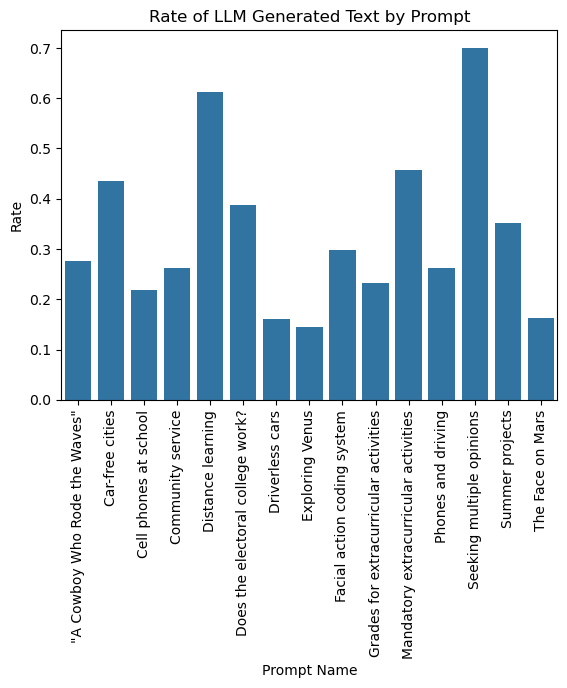

In [4]:
df_plt = train.groupby('prompt_name').label.mean().reset_index()

sns.barplot(x='prompt_name',
            y='label',
            data=df_plt)
plt.ylabel('Rate')
plt.title('Rate of LLM Generated Text by Prompt')
plt.xlabel('Prompt Name')
plt.xticks(rotation=90)
plt.show()

In [5]:
train.groupby('prompt_name').size()

prompt_name
"A Cowboy Who Rode the Waves"            1896
Car-free cities                          4717
Cell phones at school                    2119
Community service                        2092
Distance learning                        5554
Does the electoral college work?         4434
Driverless cars                          2250
Exploring Venus                          2176
Facial action coding system              3084
Grades for extracurricular activities    2116
Mandatory extracurricular activities     3077
Phones and driving                       1583
Seeking multiple opinions                5176
Summer projects                          2701
The Face on Mars                         1893
dtype: int64

## Word Frequencies

First, subset to just the "Car-free cities" prompt because I want to make the problem smaller and more feasible, for now. 

I also don't want to deal with the fact that different prompts have different ratios of AI to non AI text. In this case, modeling could get ok performance not by studying the structure of the text (is the language used in an "AI like way") but by the content (for example, in "Seeking Multiple Opinions" 70% of the data is AI generated). 

It is probably possible to handle this with downsampling or bootstrapping, but I'll save that for a later date, if I have the time. 

In [5]:
train_subset = train[train.prompt_name == 'Car-free cities']

In [6]:
train_subset.label.mean()

0.43481026075895696

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(train_subset, test_size=0.4, random_state=5)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=5)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer


In [10]:
train_ai = df_train[df_train.label==1]
train_human = df_train[df_train.label==0]

In [11]:
def get_word_freq(df: pd.DataFrame) -> pd.DataFrame:
    """Gets the word frequencies in the essay data"""

    cv = CountVectorizer()   
    cv_fit = cv.fit_transform(df.text.values)    
    word_list = cv.get_feature_names_out()
    
    count_list = np.asarray(cv_fit.sum(axis=0))[0]
    
    count_dict = dict(zip(word_list, count_list / count_list.sum()))
    count_dict = {k:[v] for k, v in count_dict.items()}
    
    count_df = pd.DataFrame(count_dict)
    count_df = count_df.melt()
    count_df.columns = ['token', 'frequency']
    count_df['n'] = count_list.sum()
    count_df['count'] =  count_df.n * count_df.frequency
    count_df = count_df.sort_values('frequency', ascending=False)
    return count_df


In [12]:
ai_freq = get_word_freq(train_ai)
human_freq = get_word_freq(train_human)

/tmp/ipykernel_12962/2641180536.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  count_df = count_df.melt()
/tmp/ipykernel_12962/2641180536.py:14: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  count_df = count_df.melt()


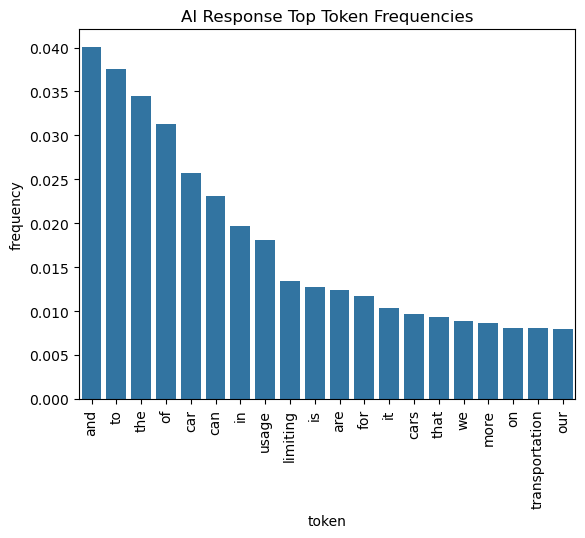

In [13]:
top_ai_freq = ai_freq.sort_values('frequency', ascending=False).iloc[:20]


sns.barplot(x='token',
            y='frequency',
            data=top_ai_freq)
plt.xticks(rotation=90)
plt.title('AI Response Top Token Frequencies')
plt.show()

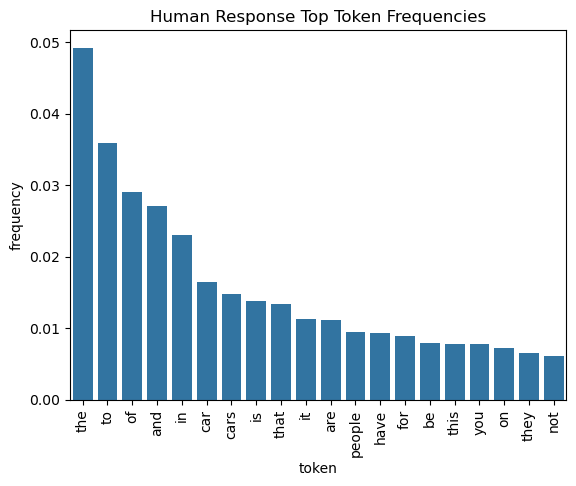

In [14]:
top_human_freq = human_freq.sort_values('frequency', ascending=False).iloc[:20]


sns.barplot(x='token',
            y='frequency',
            data=top_human_freq)
plt.xticks(rotation=90)
plt.title('Human Response Top Token Frequencies')
plt.show()

There is a very obvious token discrepancy between the two responses. This is worth exploring more rigorously, with TF-IDF being the end goal. 


## Token Discrepancies

Use the law of large numbers for a normal approx. Grab everything with over 500 mentions in each document. 

In [15]:
K = 500

common_tokens = ai_freq[ai_freq['count'] >= K].merge(human_freq[human_freq['count'] >= K],
                                       on='token',
                                       how='inner')

Follow the discussion [here](https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other) for a z score.

In [16]:
from scipy.stats import false_discovery_control, norm

def two_group_binomial_p_value(row):
    p1= row.frequency_y
    p2= row.frequency_x

    n1 = row.n_y
    n2 = row.n_x

    p = (n1 * p1 + n2*p2) / (n1 + n2)

    z = (p1 - p2) / ((p * (1-p) * (1/n1 + 1/n2)) ** (1/2))

    return norm.sf(abs(z)) * 2

In [17]:
common_tokens['p_value'] = common_tokens.apply(two_group_binomial_p_value,axis=1)

Control the p values using a benjamini hochberg procedure. 

In [18]:
common_tokens['bh_p_value'] = false_discovery_control(common_tokens.p_value)
common_tokens['human_to_ai_frequency_delta'] = (common_tokens.frequency_x/ common_tokens.frequency_y - 1) * 100

In [19]:
common_tokens_reject = common_tokens[common_tokens.bh_p_value < 0.05]

In [20]:
top_deltas = common_tokens_reject[common_tokens_reject.human_to_ai_frequency_delta.abs() >= \
                common_tokens_reject.human_to_ai_frequency_delta.abs().quantile(.9)]

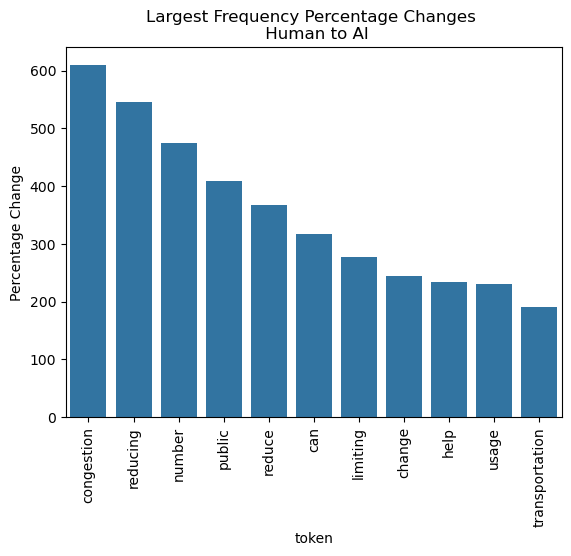

In [21]:
sns.barplot(x='token',
            y='human_to_ai_frequency_delta',
            data=top_deltas.sort_values('human_to_ai_frequency_delta', ascending=False))
plt.xticks(rotation=90)
plt.ylabel('Percentage Change')
plt.title('Largest Frequency Percentage Changes \n Human to AI')
plt.show()

## TF IDF

This makes me think it is possible to do some classification here. 

Only use those features that BH determined where statisically different. 

In [22]:
tokens_keep = common_tokens_reject.token.values

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report


X_train = df_train.text.values
y_train = df_train.label.values

X_val = df_val.text.values
y_val = df_val.label.values


# Build the pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(vocabulary=tokens_keep)), 
    ("classifier", RandomForestClassifier(random_state=5)),
])

# Define the hyperparameter grid
param_grid = {
    "classifier__n_estimators": [10, 50, 100, 200],  # Number of trees
    "classifier__max_depth": [5, 10, 20, 30],  # Maximum depth of the trees
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 3-fold cross-validation
    scoring="f1",  # Metric for evaluation
    verbose=1,
    n_jobs=-1,  # Use all available cores
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Display the best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
print("\nBest Estimator:\n", grid_search.best_estimator_)

# Test the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Evaluate the model
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}

Best Estimator:
 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(vocabulary=array(['and', 'to', 'the', 'of', 'car', 'can', 'in', 'usage', 'limiting',
       'is', 'are', 'for', 'it', 'cars', 'that', 'we', 'more', 'on',
       'transportation', 'our', 'reduce', 'air', 'by', 'this', 'public',
       'help', 'also', 'pollution', 'traffic', 'congestion', 'there',
       'emissions', 'have', 'people', 'be', 'reducing', 'gas', 'number',
       'make...
       'walking', 'take', 'your', 'if', 'like', 'source', 'walk', 'would',
       'way', 'another', 'may', 'will', 'but', 'community', 'life',
       'time', 'been', 'vauban', 'an', 'do', 'areas', 'ways', 'up',
       'example', 'cause', 'all', 'states', 'paris', 'instead', 'about',
       'united', 'without', 'work', 'world', 'while'], dtype=object))),
                ('classifier',
         

Perfect prediction is actually quite surprising. Makes we wonder about the value of the data to be honest. 


But whatever. 

In [24]:
#df_train[df_train.label == 0].text.values[1]

In [25]:
#df_train[df_train.label == 1].text.values[-1]

In [26]:
pd.read_csv('train_prompts.csv')#.instructions.values[1]

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [27]:
#print(pd.read_csv('train_prompts.csv').source_text.values[0])

## Problem Reformulation

It seems as though the issue is not using the training set to predict AI text - this can be accomplished using really easily, but rather predicting whether or not NEW text is actually AI generated. 


So... let's return to the statistical testing approach, but this time only look at stop words

In [28]:
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS

In [29]:
K = 100

common_tokens = ai_freq[ai_freq['count'] >= K].merge(human_freq[human_freq['count'] >= K],
                                       on='token',
                                       how='inner')

In [30]:
common_tokens['p_value'] = common_tokens.apply(two_group_binomial_p_value,axis=1)

In [31]:
common_tokens = common_tokens[common_tokens.token.isin(my_stop_words)]

In [32]:
common_tokens['bh_p_value'] = false_discovery_control(common_tokens.p_value)


In [33]:
common_tokens = common_tokens[common_tokens.bh_p_value <= 0.05]

In [4]:
new_val = train[train.prompt_name == "Does the electoral college work?"]

In [35]:
tokens_keep = common_tokens.token.values

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report


X_train = df_train.text.values
y_train = df_train.label.values

X_val = new_val.text.values
y_val = new_val.label.values


# Build the pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(vocabulary=tokens_keep)), 
    ("classifier", RandomForestClassifier(random_state=5)),
])

# Define the hyperparameter grid
param_grid = {
    "classifier__n_estimators": [10, 50, 100, 200],  # Number of trees
    "classifier__max_depth": [5, 10, 20, 30],  # Maximum depth of the trees
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 3-fold cross-validation
    scoring="f1",  # Metric for evaluation
    verbose=1,
    n_jobs=-1,  # Use all available cores
)

# Perform grid search
grid_search.fit(X_train, y_train)

# Display the best parameters and estimator
print("Best Parameters:", grid_search.best_params_)
print("\nBest Estimator:\n", grid_search.best_estimator_)

# Test the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Evaluate the model
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 50}

Best Estimator:
 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(vocabulary=array(['and', 'to', 'the', 'of', 'can', 'in', 'is', 'are', 'for', 'it',
       'that', 'we', 'more', 'on', 'our', 'by', 'this', 'also', 'there',
       'have', 'be', 'has', 'which', 'you', 'they', 'with', 'these',
       'many', 'such', 'one', 'get', 'from', 'not', 'less', 'their',
       'other', 'when', 'take', 'your', 'if', 'would', 'another', 'may',
       'will', 'but',...
       'become', 'than', 'both', 'most', 'everyone', 'often', 'at',
       'even', 'own', 'find', 'how', 'was', 'its', 'over', 'too', 'why',
       'my', 'go', 'those', 'made', 'much', 'third', 'out', 'each',
       'done', 'per', 'give', 'already', 'now', 'because', 'were',
       'found', 'move', 'during', 'here', 'what'], dtype=object))),
                ('classifier',
                

In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")

Recall is 0.06744186046511629
Precision is 0.9508196721311475
f1 is 0.1259500542888165
Accuracy is 0.6368967072620658


#### Stopword Specific model on question specific stopwords

This model still performs VERY well on the same topic using only stop words. 

In [38]:
X_val = df_val.text.values
y_val = df_val.label.values
y_pred = best_model.predict(X_val)


recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")

Recall is 0.9496567505720824
Precision is 0.9857482185273159
f1 is 0.9673659673659674
Accuracy is 0.9703075291622482


Now the problem makes much more sense - we want to learn broader patterns about AI text and apply them across contexts


## Recurrence

My previous frequency works assume that what comes out of the text is random, but we know that is not the case. Here, I'm going to try to leverage the recurrence of LLMs. 

From Bayes theorem, the probability that text is AI is proportional to the probabilty that AI generates text, so I will now generate the log likelihoods of response in the train and test sets. I am very curious about this way of studying large language models. 

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train_v2_drcat_02.csv')
train_subset = train[train.prompt_name == 'Car-free cities']
df_train, df_val = train_test_split(train_subset, test_size=0.4, random_state=5)
df_val, df_test = train_test_split(df_val, test_size=0.5, random_state=5)


new_val = train[train.prompt_name == "Does the electoral college work?"]

Matplotlib is building the font cache; this may take a moment.


In [4]:
import torch

In [5]:
torch.cuda.is_available()

True

In [7]:
#! touch token.txt

In [9]:
from huggingface_hub import login


file = open("token.txt", "r")
HF_token = file.read()
file.close()

login(HF_token)

In [12]:
#! pip install transformers

In [13]:
import transformers

In [14]:
# #del model
# del tokenizer
# torch.cuda.empty_cache()
# gc.collect()

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantization_config = BitsAndBytesConfig(load_in_8bit=True)


model_name = "mistralai/Mistral-7B-Instruct-v0.2" 
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto", 
    quantization_config=quantization_config,
    #torch_dtype=torch.float16,  
    use_auth_token=True      
)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [16]:
import gc

def get_log_likelihood(input_text: str) -> int:
    """Uses the llm to calculate the log likelihood of the text"""
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)

    input_ids = input_ids[:, :-1]
    target_ids = input_ids[:, 1:]

    # Get the model output (logits)
    with torch.no_grad():  
        outputs = model(input_ids)

        logits = outputs.logits


        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        target_log_probs = log_probs[:, range(target_ids.size(1)), target_ids.squeeze()]
        
        target_ids = target_ids.cpu()
        logits = logits.cpu()
        
        rv =  target_log_probs.cpu().numpy().sum()
        

        del input_ids
        del logits
        del log_probs
        del target_log_probs
        del outputs
        del target_ids
        gc.collect()
        torch.cuda.empty_cache()
        gc.collect()
    return rv



In [18]:
from tqdm.auto import tqdm

llm_train = pd.concat([df_train, df_val])
texts = llm_train.text.values
likelhoods = [get_log_likelihood(x) for x in tqdm(texts)]

llm_train['log_likelihood'] = likelhoods 

In [19]:
llm_test = df_test.copy()
texts = llm_test.text.values
likelihoods = [get_log_likelihood(x) for x in tqdm(texts)]

llm_test['log_likelihood'] = likelihoods

  0%|          | 0/944 [00:00<?, ?it/s]

In [20]:
llm_train.to_csv('llm_log_likelihood_train.csv',index=False)
llm_test.to_csv('llm_log_likelihood_test.csv', index=False)

In [22]:
llm_train.groupby('label').log_likelihood.mean()

label
0   -1673.241455
1    -589.888000
Name: log_likelihood, dtype: float32

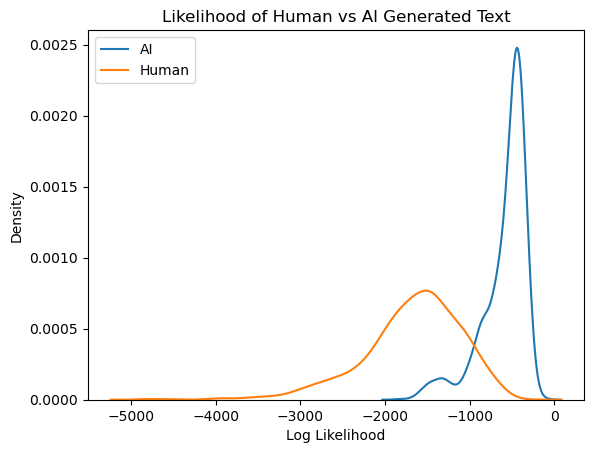

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

ai_idx = llm_train.label == 1


f = plt.figure()
sns.kdeplot(llm_train[ai_idx].log_likelihood, label='AI')
sns.kdeplot(llm_train[~ai_idx].log_likelihood, label='Human')
plt.legend()

plt.xlabel('Log Likelihood')
plt.title('Likelihood of Human vs AI Generated Text')
plt.show()

While statistically different, log likelihood does not effectively partition the data. 


Let's use kmeans clustering to determine which density we belong to. 

I do this because I want a technique that does not rely on calibration but rather can be applied to whatever problem set is necessary. As evidenced with the TF-IDF, we can get near perfect performance if we are accurately calibrated to the test density, but we may not have that luxury. Instead of using a hard cutoff for the log likelihood (which must be calibrated), I instead use an unsupervised technique that does not require calibration (but does require a SET of observations, not a single instance). 

In [50]:
from sklearn.cluster import KMeans
import numpy as np

df_eval = pd.concat([llm_train, llm_test])

X = df_eval.log_likelihood.values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)


In [51]:
kmeans.cluster_centers_

array([[ -663.73338942],
       [-1884.78837978]])

The AI willhave the smaller cluster center

In [52]:
ai_label = kmeans.predict([[-1]])[0]

is_ai = (kmeans.predict(X) == ai_label).astype(int)


y_pred = is_ai
y_true = df_eval.label.values

In [53]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")

Recall is 0.9551438322769381
Precision is 0.752593161736458
f1 is 0.8418564675547916
Accuracy is 0.8439686241255036


### Addendum - add the calibration

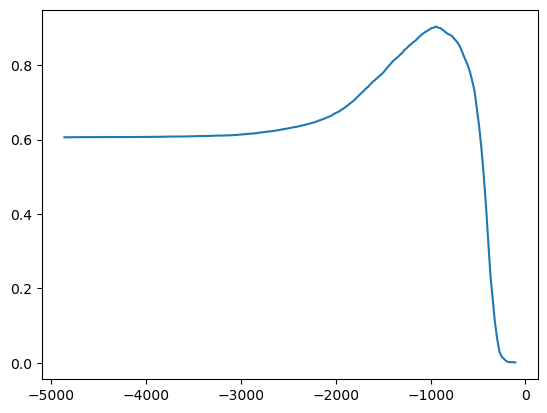

In [63]:
l = X.flatten()
y = df_eval.label.values

cutoffs = np.linspace(l.min(), l.max(), 200)

f1s = [f1_score(y, (l >= c).astype(int)) for c in cutoffs]

plt.plot(cutoffs, f1s)
plt.show()

In [65]:
best_cutoff = cutoffs[np.argmax(f1s)]

print(best_cutoff)

-943.0062814070347


In [66]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_pred = (l >= best_cutoff).astype(int)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")

Recall is 0.9034617259873232
Precision is 0.9043435822352367
f1 is 0.9039024390243903
Accuracy is 0.9164723341106635


This does decently well. Not as well as the original, of course, but it may potentially generalize better. 


Also,both the distribution and the cutoff approach each work pretty well. 


Now, we will try on the Electoral college dataset. 

## Electoral College Fitting

In [44]:
llm_ec = new_val.copy()
texts = llm_ec.text.values
likelihoods = [get_log_likelihood(x) for x in tqdm(texts)]

llm_ec['log_likelihood'] = likelihoods

  0%|          | 0/4434 [00:00<?, ?it/s]

In [45]:
llm_ec.to_csv('llm_log_likelihood_electoral_college_validation.csv',index=False)


In [47]:
llm_ec.groupby('label').log_likelihood.mean()

label
0   -1405.011719
1    -604.625061
Name: log_likelihood, dtype: float32

In [67]:
df_eval = llm_ec.copy()

# cluster
X = df_eval.log_likelihood.values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)

# get labels
ai_label = kmeans.predict([[-1]])[0]
is_ai = (kmeans.predict(X) == ai_label).astype(int)
y_pred = is_ai
y_true = df_eval.label.values


recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")


Recall is 0.897093023255814
Precision is 0.6239385361908613
f1 is 0.7359885523491534
Accuracy is 0.7503382949932341


This gets an f1 of 0.74, as opposed to 0.12. 

So, I was right to think that leveraging the recurrent text structure is better than a bag of words. 

That being said, this is clearly not amazing. Also, it is an aggregate prediction method - sure, the results work well here, but they assume you have enough data to perform the statistical clustering. OR you could deal with the calibration issues. 


#### Test with cutoffs

In [68]:
y_true = df_eval.label.values

y_pred = (df_eval.log_likelihood >= best_cutoff).astype(int)


recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")


Recall is 0.8029069767441861
Precision is 0.7357485348961108
f1 is 0.7678621073116486
Accuracy is 0.811682453766351


Using the cutoff is actually a little better than k-means. Glad I did that experiment. However, I'm not convinced there is any reason this should ALWAYS hold. I like the theoretical justification for k means a little better. But then you have the aggregate problem. 



This feels like an inherently noisy process, and, since it is one dimensional, it may not capture all the nuance of the language. 

Intuitively, I think there are most likely certain patterns of language/ turns of phrase that indicate AI text. These may be too complex for a bag of words but so rare that they may get lost in the noise of the log likelihood appraoch. 

I think a finetune of a pretrained classifier like BERT may be in order. That will be my next experiment. 


## AI Finetune



After doing some more work, I think it makes the most sense to only train on a smaller number of documents - maybe 10k, not 30. This is a time consuming process and training on AWS GPUs is pretty expensive. 

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train_v2_drcat_02.csv')
test = train[train.prompt_name == "Does the electoral college work?"]
train = train[train.prompt_name != "Does the electoral college work?"]



prompts = train.prompt_name.unique().tolist()
n_prompts = len(prompts)
val_size = 0.2
val_idx = n_prompts - int(val_size * n_prompts)

train_keep_prompts = [
    'Car-free cities',
    'Facial action coding system',
    'Grades for extracurricular activities'
]

val = train[train.prompt_name.isin(prompts[val_idx:])]
train = train[train.prompt_name.isin(train_keep_prompts)]



print(f"Training size: {len(train)}")
print(f"Validation size: {len(val)}")


Training size: 9917
Validation size: 10730


In [3]:
test.source.value_counts()

persuade_corpus                       2046
kingki19_palm                          672
train_essays                           670
radek_500                              250
NousResearch/Llama-2-7b-chat-hf        200
mistralai/Mistral-7B-Instruct-v0.1     200
radekgpt4                              100
darragh_claude_v7                       74
darragh_claude_v6                       56
cohere-command                          50
palm-text-bison1                        49
llama_70b_v1                            31
falcon_180b_v1                          25
mistral7binstruct_v1                     5
chat_gpt_moth                            3
llama2_chat                              2
mistral7binstruct_v2                     1
Name: source, dtype: int64

In [5]:
train.source.value_counts()

persuade_corpus                       5752
kingki19_palm                          712
train_essays                           708
llama_70b_v1                           394
falcon_180b_v1                         332
llama2_chat                            279
radek_500                              250
NousResearch/Llama-2-7b-chat-hf        200
mistralai/Mistral-7B-Instruct-v0.1     199
darragh_claude_v6                      188
darragh_claude_v7                      183
mistral7binstruct_v1                   183
mistral7binstruct_v2                   122
chat_gpt_moth                          117
radekgpt4                              100
palm-text-bison1                        99
cohere-command                          99
Name: source, dtype: int64

I am curious how the model generalizes to data it has not seen during training. So, I will drop the [PALM](https://en.wikipedia.org/wiki/PaLM) prompts the training set. 

In [7]:
test[test.source == 'kingki19_palm'].label.mean()

1.0

In [8]:
train[train.source == 'kingki19_palm'].label.mean()

1.0

In [12]:
train = train[train.source != 'kingki19_palm']

In [13]:
len(train)

9205

In [15]:
#! pip install accelerate && pip install transformers && pip install bitsandbytes && pip install tiktoken && pip install sentencepiece

In [16]:
from huggingface_hub import login


file = open("token.txt", "r")
HF_token = file.read()
file.close()

login(HF_token)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

In [18]:
model_name = "google/bigbird-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenize Data and set up training

In [10]:
max_token_length = 4096


class TextDataset(Dataset):
    """
    Pytorch dataset for the text data
    
    """
    def __init__(self, texts, labels, tokenizer, max_token_length):
        self.input_ids, self.attention_mask, self.labels = self.tokenize_data(texts, 
                                                                              labels, 
                                                                              tokenizer, 
                                                                              max_token_length)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }
    
    def tokenize_data(self, texts, labels, tokenizer, max_token_length):
        inputs = tokenizer(
            texts,
            max_length=max_token_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels)


In [20]:
#k = 300

# train = train.iloc[:2*k]
# val = val.iloc[:k]


train_texts = train.text.values.tolist()
train_labels = train.label.values

val_texts = val.text.values.tolist()
val_labels = val.label.values


train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_token_length)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_token_length)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [21]:
import os

optimizer = AdamW(model.parameters(), lr=1e-5)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.nn.DataParallel(model)
model.to(device)

# Directory for saving models and checkpoints
save_dir = "model_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Training Loop with Checkpoints
epochs = 3#= #should be more, this is just a prototype
best_val_loss = float("inf")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


There is definitely a lot of possible engineering to speed up the parallel training. I would probably use multi processing, since I have a suspicion that the dataparallel class does not move data to the different GPUs as efficiently as possible (less power used per GPU than if I did it sequentially). 

However, I am looking at this project mostly as a prototype. This would be a very obvious way to improve the functionality if given more time and resources. 

In [22]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss.sum()
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss}")
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.sum().item()
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = os.path.join(save_dir, "best_model.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, best_model_path)
        print(f"Best model saved at {best_model_path}")



  0%|          | 0/1151 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 1151/1151 [1:13:42<00:00,  3.84s/it]


Epoch 1, Training Loss: 0.1899325282045508


100%|██████████| 1342/1342 [10:02<00:00,  2.23it/s]


Epoch 1, Validation Loss: 0.2288, Accuracy: 0.9851
Best model saved at model_checkpoints/best_model.pt


100%|██████████| 1151/1151 [1:13:29<00:00,  3.83s/it]


Epoch 2, Training Loss: 0.040792129778782216


100%|██████████| 1342/1342 [10:01<00:00,  2.23it/s]


Epoch 2, Validation Loss: 0.2800, Accuracy: 0.9824


100%|██████████| 1151/1151 [1:13:14<00:00,  3.82s/it]


Epoch 3, Training Loss: 0.02801488095626023


100%|██████████| 1342/1342 [10:01<00:00,  2.23it/s]

Epoch 3, Validation Loss: 0.3307, Accuracy: 0.9736


In [23]:
# Save final model and tokenizer
final_model_path = os.path.join(save_dir, "final_model")
os.makedirs(final_model_path, exist_ok=True)

model.module.save_pretrained(final_model_path)
tokenizer.save_pretrained(final_model_path)
print(f"Final model and tokenizer saved at {final_model_path}")

Final model and tokenizer saved at model_checkpoints/final_model


In [24]:
train_df = pd.DataFrame({
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies
})


train_df.to_csv('train_losses.csv',index=False)

## Load in the best model and do inference on the test set

In [1]:
best_model_path = 'model_checkpoints/best_model.pt'
final_model_path = 'model_checkpoints/final_model'

In [2]:
#torch.load(best_model_checkpoint['model_state_dict'])

In [3]:
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

best_model_checkpoint = torch.load(best_model_path)

new_state_dict = {}
for k, v in best_model_checkpoint['model_state_dict'].items():
    new_key = k.replace('module.', '')
    new_state_dict[new_key] = v

# Reinitialize the model architecture (use the same model type as during training)
model = AutoModelForSequenceClassification.from_pretrained("google/bigbird-roberta-base")  
tokenizer = AutoTokenizer.from_pretrained(final_model_path)

model.load_state_dict(new_state_dict)

# Ensure the model is in evaluation mode
model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(50358, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

I'm wondering if this weird `\xa0` string that is never in the `1` class is responsible for the good performance. It is not. 

In [39]:
test_texts = test.text.map(lambda x: x.replace('\xa0', '')).values.tolist()
test_labels = test.label.values


test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_token_length)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [40]:
from tqdm import tqdm

model.eval()
test_results = []
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        predictions = torch.argmax(outputs.logits, dim=1)
        test_results += predictions.tolist()

100%|██████████| 555/555 [09:25<00:00,  1.02s/it]


In [41]:
test['predicted_label'] = test_results

In [42]:
test.to_csv('test_set_with_predictions.csv', index=False)

### Evaluate Test Set Performance

In [43]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

y_true = test.label.values

y_pred = test.predicted_label.values


recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")

Recall is 0.9744186046511628
Precision is 0.995249406175772
f1 is 0.9847238542890717
Accuracy is 0.9882724402345512


Almost perfect performance on the test set, which is very impressive. Clearly, the finetune can generalize across contexts. 

However, can it also tell the difference for AI models it has not seen?

In [44]:
subset = test[test.source == 'kingki19_palm']


y_true = subset.label.values

y_pred = subset.predicted_label.values


recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)


print(f"Recall is {recall}")
print(f"Precision is {precision}")
print(f"f1 is {f1}")
print(f"Accuracy is {accuracy}")

Recall is 0.9642857142857143
Precision is 1.0
f1 is 0.9818181818181818
Accuracy is 0.9642857142857143


Performance is a little worse, 96% vs 98% accuracy, on the AI test set members from PALM, which was never in the training set. Still, this is pretty good. Much better than the other approaches. 

I guess you can tell AI text. 